In [155]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

In [156]:
BASE_PATH ='/home/amrutha/for-2seconds/'
MODEL_FILENAME = 'best_cnn_spectrogram.h5'

SAMPLE_RATE = 16000
DURATION = 2.0
N_MELS = 128
HOP_LENGTH = 512
N_MFCC = 40

# Training Parameters
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-4
PATIENCE = 12

# Random Seed for Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

###### =================================================================
#               FEATURE SHAPE FIX: Calculate and Normalize
# =================================================================

def get_feature_shape(sr: int = SAMPLE_RATE, duration: float = DURATION, 
                      hop_length: int = HOP_LENGTH, n_mels: int = N_MELS, 
                      n_mfcc: int = N_MFCC) -> Tuple[int, int]:
    """Calculates the fixed feature shape (height, width)."""
    # Total samples
    target_length = int(sr * duration)
    # Number of time steps (width) after STFT/Mel calculation
    # Formula: floor(1 + (N - N_FFT) / HOP_LENGTH) where N_FFT = 2048 (librosa default)
    # A safer estimate for fixed duration is based on the target length
    n_fft = 2048  # Default
    time_steps = int(np.floor(1 + (target_length - n_fft) / hop_length))
    # Feature height: N_MELS + N_MFCC
    height = n_mels + n_mfcc
    return height, time_steps

# Calculate the global target shape once
FEATURE_HEIGHT, FEATURE_WIDTH = get_feature_shape()
print(f"Calculated Target Feature Shape (Height, Width): ({FEATURE_HEIGHT}, {FEATURE_WIDTH})")


def normalize_feature_shape(feature: np.ndarray, target_height: int = FEATURE_HEIGHT, 
                            target_width: int = FEATURE_WIDTH) -> np.ndarray:
    """Pads or truncates a feature array to the fixed target shape."""
    current_height, current_width = feature.shape

    # 1. Height check (should not change if N_MELS and N_MFCC are constant)
    if current_height != target_height:
        # This is a critical error and should not happen if feature extraction is correct
        raise ValueError(f"Feature height mismatch! Expected {target_height}, got {current_height}.")

    # 2. Width (Time) check
    if current_width < target_width:
        # Pad with zeros to match target width
        padding = target_width - current_width
        feature = np.pad(feature, ((0, 0), (0, padding)), mode='constant')
    elif current_width > target_width:
        # Truncate to match target width
        feature = feature[:, :target_width]
    
    return feature

# =================================================================
#                   DATA AUGMENTATION FUNCTIONS (Unchanged)
# =================================================================

def time_stretch(audio: np.ndarray, rate: float = None) -> np.ndarray:
    """Apply time stretching to audio."""
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)
    # NOTE: Time stretching changes the length, this is handled by load_audio_file's resizing
    return librosa.effects.time_stretch(audio, rate=rate, fill_value=0) 


def pitch_shift(audio: np.ndarray, sr: int, n_steps: int = None) -> np.ndarray:
    """Apply pitch shifting to audio."""
    if n_steps is None:
        n_steps = np.random.randint(-3, 4)
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)


def add_noise(audio: np.ndarray, noise_factor: float = None) -> np.ndarray:
    """Add random noise to audio."""
    if noise_factor is None:
        noise_factor = np.random.uniform(0.001, 0.005)
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise


def spec_augment(spec: np.ndarray, 
                 num_freq_masks: int = 2, 
                 num_time_masks: int = 2) -> np.ndarray:
    """Apply SpecAugment to mel spectrogram."""
    spec = spec.copy()
    freq_bins, time_steps = spec.shape
    
    # Frequency masking
    for _ in range(num_freq_masks):
        f = np.random.randint(0, 15)
        f0 = np.random.randint(0, freq_bins - f)
        spec[f0:f0+f, :] = 0
    
    # Time masking
    for _ in range(num_time_masks):
        t = np.random.randint(0, 20)
        t0 = np.random.randint(0, time_steps - t)
        spec[:, t0:t0+t] = 0
    
    return spec

In [158]:
# =================================================================
#                   FEATURE EXTRACTION FUNCTIONS (Minor Change)
# =================================================================

def extract_mel_spectrogram(audio: np.ndarray, sr: int) -> np.ndarray:
    """Extract mel spectrogram from audio."""
    # NOTE: N_FFT default is 2048 in librosa
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


def extract_mfcc(audio: np.ndarray, sr: int) -> np.ndarray:
    """Extract MFCC features from audio."""
    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=N_MFCC, hop_length=HOP_LENGTH
    )
    return mfcc


def extract_combined_features(audio: np.ndarray, sr: int) -> np.ndarray:
    """Extract and combine mel spectrogram and MFCC features."""
    mel_spec = extract_mel_spectrogram(audio, sr)
    mfcc = extract_mfcc(audio, sr)
    
    # NOTE: The original logic here to resize MFCC to match mel_spec is now redundant
    # because the audio itself has a fixed length, meaning mel_spec and mfcc
    # should have the same number of time steps (width). The final shape normalization
    # is handled after this function.
    
    # Combine features
    combined = np.vstack([mel_spec, mfcc])
    return combined


def load_audio_file(file_path: str, 
                    augment: bool = False) -> Optional[np.ndarray]:
    """Load and process a single audio file."""
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Ensure fixed audio length *before* feature extraction
        target_length = int(SAMPLE_RATE * DURATION)
        if len(audio) < target_length:
            # Pad with zeros
            audio = np.pad(audio, (0, target_length - len(audio)))
        else:
            # Truncate
            audio = audio[:target_length]
        
        # Apply augmentation if requested
        if augment:
            # Re-check length after time_stretch
            aug_choice = np.random.choice(['time', 'pitch', 'noise', 'none'], p=[0.25, 0.25, 0.25, 0.25])
            if aug_choice == 'time':
                audio = time_stretch(audio)
            elif aug_choice == 'pitch':
                audio = pitch_shift(audio, sr)
            elif aug_choice == 'noise':
                audio = add_noise(audio)

        # Re-ensure fixed length after time augmentation (time stretch changes length)
        # This is CRITICAL for consistent feature shape
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]

        # Extract features
        features = extract_combined_features(audio, sr)
        
        # !!! FIX: Normalize feature shape to the global fixed size (FEATURE_HEIGHT, FEATURE_WIDTH)
        features = normalize_feature_shape(features)
        
        # Apply SpecAugment randomly during training
        if augment and np.random.random() < 0.3:
            features = spec_augment(features)
        
        return features
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

In [159]:
# =================================================================
#           DATA LOADING AND PREPROCESSING (Unchanged Logic)
# =================================================================

def load_and_preprocess_data(base_path: str, 
                             augment_train: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load and preprocess audio dataset.
    """
    X_list = []
    y_list = []
    
    # Define dataset splits and labels
    splits = ['train', 'test', 'validation'] if os.path.exists(os.path.join(base_path, 'validation')) else ['train', 'test']
    labels = {'real': 0, 'fake': 1}
    
    for split in splits:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue
            
        print(f"\nLoading {split} data...")
        
        for label_name, label_value in labels.items():
            label_path = os.path.join(split_path, label_name)
            
            if not os.path.exists(label_path):
                print(f"Warning: {label_path} not found, skipping...")
                continue
            
            audio_files = [f for f in os.listdir(label_path) if f.endswith('.wav')]
            print(f"  Found {len(audio_files)} {label_name} files in {split}")
            
            for i, filename in enumerate(audio_files):
                file_path = os.path.join(label_path, filename)
                
                # Apply augmentation only to training data
                apply_aug = augment_train and split == 'train'
                features = load_audio_file(file_path, augment=apply_aug)
                
                if features is not None:
                    X_list.append(features)
                    y_list.append(label_value)
                
                if (i + 1) % 100 == 0:
                    print(f"    Processed {i + 1}/{len(audio_files)} files...")
    
    # Convert to numpy arrays - This is the line that required homogeneous shapes
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Add channel dimension for CNN
    X = X[..., np.newaxis]
    
    print(f"\nTotal samples loaded: {len(X)}")
    print(f"Feature shape: {X.shape}")
    print(f"Label distribution: Real={np.sum(y==0)}, Fake={np.sum(y==1)}")
    
    return X, y

In [160]:
# =================================================================
#                   MODEL ARCHITECTURE (Unchanged)
# =================================================================

def build_advanced_cnn_model(input_shape: Tuple[int, int, int]) -> keras.Model:
    """
    Build an advanced CNN model with residual connections and attention.
    """
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Residual Block 1
    residual = x
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Adjust residual dimensions if needed
    residual = layers.Conv2D(64, (1, 1), padding='same')(residual)
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Residual Block 2
    residual = x
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    residual = layers.Conv2D(128, (1, 1), padding='same')(residual)
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Residual Block 3
    residual = x
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    residual = layers.Conv2D(256, (1, 1), padding='same')(residual)
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='DeepfakeDetector')
    return model

In [161]:
# =================================================================
#               TRAINING AND EVALUATION (Unchanged Logic)
# =================================================================

def plot_training_history(history):
    """Plot training history."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


def evaluate_model(model, X_test, y_test, threshold=0.5):
    """Comprehensive model evaluation."""
    print("\n" + "="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    
    # Predictions
    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob >= threshold).astype(int)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\nTest Accuracy : {accuracy:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print(f"ROC-AUC Score : {roc_auc:.4f}")
    print(f"Threshold     : {threshold}\n")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=['Real', 'Fake'], 
                                digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'], ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_title('ROC Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, linewidth=2)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return accuracy, roc_auc, f1


def predict_single_file(model, file_path: str, threshold: float = 0.5):
    """Predict whether a single audio file is real or fake."""
    print(f"\n{'='*60}")
    print("SINGLE FILE PREDICTION")
    print(f"{'='*60}")
    print(f"File: {os.path.basename(file_path)}")
    
    features = load_audio_file(file_path, augment=False)
    
    if features is None:
        print("[ERROR] Could not load audio file")
        return
    
    # Add batch and channel dimensions
    features = features[np.newaxis, ..., np.newaxis]
    
    # Predict
    prob = model.predict(features, verbose=0)[0][0]
    prediction = "FAKE" if prob >= threshold else "REAL"
    
    print(f"\nPrediction    : {prediction}")
    print(f"Confidence    : {prob:.4f}")
    print(f"Threshold     : {threshold}")
    print(f"{'='*60}\n")
    
    return prediction, prob

In [162]:
# =================================================================
#                       MAIN EXECUTION (Unchanged Logic)
# =================================================================

def main():
    """Main execution function."""
    
    print("\n" + "="*60)
    print("AUDIO DEEPFAKE DETECTION SYSTEM")
    print("="*60)
    
    # -------------------------------------------------------------
    # 1. Load and Prepare Data
    # -------------------------------------------------------------
    print("\n[1/6] Loading and preprocessing data...")
    X, y = load_and_preprocess_data(BASE_PATH, augment_train=True)
    
    # Split Dataset (70% Train, 15% Val, 15% Test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=RANDOM_SEED, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=RANDOM_SEED, stratify=y_temp
    )
    
    print("\nDataset shapes:")
    print(f"  Train: {X_train.shape}, {y_train.shape}")
    print(f"  Val  : {X_val.shape}, {y_val.shape}")
    print(f"  Test : {X_test.shape}, {y_test.shape}")
    
    # Calculate class weights for imbalanced datasets
    class_weights = {
        0: len(y_train) / (2 * np.sum(y_train == 0)),
        1: len(y_train) / (2 * np.sum(y_train == 1))
    }
    print(f"\nClass weights: {class_weights}")
    
    # -------------------------------------------------------------
    # 2. Build and Compile Model
    # -------------------------------------------------------------
    print("\n[2/6] Building model...")
    input_shape = X_train.shape[1:]
    model = build_advanced_cnn_model(input_shape)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\nModel input shape: {input_shape}")
    model.summary()
    
    # -------------------------------------------------------------
    # 3. Train Model
    # -------------------------------------------------------------
    print("\n[3/6] Training model...")
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss', 
            patience=PATIENCE, 
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            MODEL_FILENAME, 
            monitor='val_loss', 
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=6, 
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    print("\n[Training Completed]")
    
    # -------------------------------------------------------------
    # 4. Plot Training History
    # -------------------------------------------------------------
    print("\n[4/6] Plotting training history...")
    plot_training_history(history)
    
    # -------------------------------------------------------------
    # 5. Load Best Model and Evaluate
    # -------------------------------------------------------------
    print("\n[5/6] Loading best model and evaluating...")
    
    try:
        best_model = keras.models.load_model(MODEL_FILENAME)
        print(f"Loaded best model: {MODEL_FILENAME}")
    except Exception as e:
        print(f"Could not load checkpoint: {e}")
        print("Using the final trained model instead.")
        best_model = model
    
    accuracy, roc_auc, f1 = evaluate_model(best_model, X_test, y_test, threshold=0.5)
    
    # -------------------------------------------------------------
    # 6. Test Single File Prediction
    # -------------------------------------------------------------
    print("\n[6/6] Testing single file prediction...")
    
    # Try to find a sample file
    sample_file = None
    for split in ['test', 'train']:
        for label in ['fake', 'real']:
            test_dir = os.path.join(BASE_PATH, split, label)
            if os.path.exists(test_dir):
                files = [f for f in os.listdir(test_dir) if f.endswith('.wav')]
                if files:
                    sample_file = os.path.join(test_dir, files[0])
                    break
        if sample_file:
            break
    
    if sample_file and os.path.exists(sample_file):
        predict_single_file(best_model, sample_file, threshold=0.5)
    else:
        print("\n[INFO] No sample file found for single prediction test.")
    
    print("\n" + "="*60)
    print("PROCESS COMPLETE!")
    print("="*60)
    print(f"\nFinal Results:")
    print(f"  Test Accuracy : {accuracy:.4f}")
    print(f"  F1 Score      : {f1:.4f}")
    print(f"  ROC-AUC       : {roc_auc:.4f}")
    print(f"\nModel saved as: {MODEL_FILENAME}")
    print("="*60 + "\n")


if __name__ == "__main__":
    main()


AUDIO DEEPFAKE DETECTION SYSTEM

[1/6] Loading and preprocessing data...

Loading train data...
  Found 6978 real files in train
Error loading /home/amrutha/for-2seconds/train/real/file10009.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav: stft() got an unexpected keyword argument 'fill_value'
Error loading /home/amrutha/for-2seconds/train/real/file10033.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav: stft() got an unexpected keyword argument 'fill_value'
Error loading /home/amrutha/for-2seconds/train/real/file10049.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav: stft() got an unexpected keyword argument 'fill_value'
Error loading /home/amrutha/for-2seconds/train/real/file10055.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav: stft() got an unexpected keyword argument 'fill_value'
Error loading /home/amrutha/for-2seconds/train/real/file10059.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav: stft() got an unexpected keyword argument 'fill_value'
Error loading /home/amrut

Model: "DeepfakeDetector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 168, 59,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 168, 59,   │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 168, 59,   │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 168, 59,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 84, 29,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 84, 29,    │          0 │ max_pooling2d_12… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 84, 29,    │     18,496 │ dropout_20[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 84, 29,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 84, 29,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 84, 29,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 84, 29,    │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 84, 29,    │      2,112 │ dropout_20[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 84, 29,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 84, 29,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 42, 14,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 42, 14,    │          0 │ max_pooling2d_13… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 42, 14,    │     73,856 │ dropout_21[0][0]

 Total params: 1,475,841 (5.63 MB)

 Trainable params: 1,472,449 (5.62 MB)

 Non-trainable params: 3,392 (13.25 KB)


[3/6] Training model...
Epoch 1/100


I0000 00:00:1763637888.567345    2904 service.cc:152] XLA service 0x55556a146be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763637888.567589    2904 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
I0000 00:00:1763637888.567624    2904 service.cc:160]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
I0000 00:00:1763637888.567644    2904 service.cc:160]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-11-20 11:24:49.477043: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-20 11:24:55.689375: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6072', 32 bytes spill stores, 32 bytes spill loads

2025-11-20 11:24:55

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 758, in start

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/ipykernel/utils.py", line 71, in preserve_context

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 614, in shell_main

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_shell

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 366, in execute_request

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 827, in execute_request

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 458, in do_execute

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 663, in run_cell

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_1984/2602683064.py", line 149, in <module>

  File "/tmp/ipykernel_1984/2602683064.py", line 81, in main

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 399, in fit

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 241, in function

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in multi_step_on_iterator

  File "/home/amrutha/miniconda3/envs/mini/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 125, in wrapper

CUDNN_STATUS_EXECUTION_FAILED
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(6402): 'status'
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_69444]

In [123]:
rm -rf for-2seconds

In [127]:
BASE_PATH = "/home/amrutha/for-2seconds/training"

print("Loading dataset...")
X, y = load_audio_dataset(BASE_PATH)

print("\nDataset loaded!")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Real samples:", sum(y == 0))
print("Fake samples:", sum(y == 1))

Loading dataset...

Loading: /home/amrutha/for-2seconds/training/real

Loading: /home/amrutha/for-2seconds/training/fake

Dataset loaded!
X shape: (13956, 40)
y shape: (13956,)
Real samples: 6978
Fake samples: 6978


In [170]:
#best final model mini

TensorFlow GPU configuration failed: Physical devices cannot be modified after being initialized

AUDIO DEEPFAKE DETECTION SYSTEM

[1/6] Loading and preprocessing data...

Loading train data...
  Found 6978 real files in train
    Processed 100/6978 files...
    Processed 200/6978 files...
    Processed 300/6978 files...
    Processed 400/6978 files...
    Processed 500/6978 files...
    Processed 600/6978 files...
    Processed 700/6978 files...
    Processed 800/6978 files...
    Processed 900/6978 files...
    Processed 1000/6978 files...
    Processed 1100/6978 files...
    Processed 1200/6978 files...
    Processed 1300/6978 files...
    Processed 1400/6978 files...
    Processed 1500/6978 files...
    Processed 1600/6978 files...
    Processed 1700/6978 files...
    Processed 1800/6978 files...
    Processed 1900/6978 files...
    Processed 2000/6978 files...
    Processed 2100/6978 files...
    Processed 2200/6978 files...
    Processed 2300/6978 files...
    Processed 2400/6978

Model: "DeepfakeDetector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 168, 59,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 168, 59,   │        320 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 168, 59,   │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 168, 59,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 84, 29,    │          0 │ activation_7[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 84, 29,    │          0 │ max_pooling2d_16… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 84, 29,    │     18,496 │ dropout_26[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 84, 29,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 84, 29,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 84, 29,    │     36,928 │ activation_8[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 84, 29,    │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 84, 29,    │      2,112 │ dropout_26[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 84, 29,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 84, 29,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 42, 14,    │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 42, 14,    │          0 │ max_pooling2d_17… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 42, 14,    │     73,856 │ dropout_27[0][0]

 Total params: 1,475,841 (5.63 MB)

 Trainable params: 1,472,449 (5.62 MB)

 Non-trainable params: 3,392 (13.25 KB)


[3/6] Training model...
Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5304 - loss: 0.9662
Epoch 1: val_loss improved from None to 0.68268, saving model to best_cnn_spectrogram.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 44ms/step - accuracy: 0.5580 - loss: 0.8990 - val_accuracy: 0.6433 - val_loss: 0.6827 - learning_rate: 1.0000e-04
Epoch 2/100
779/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6352 - loss: 0.7516
Epoch 2: val_loss did not improve from 0.68268
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6539 - loss: 0.7182 - val_accuracy: 0.6679 - val_loss: 0.8577 - learning_rate: 1.0000e-04
Epoch 3/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7051 - loss: 0.6338
Epoch 3: val_loss improved from 0.68268 to 0.68138, saving model to best_cnn_spectrogram.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7180 - loss: 0.6030 - val_accuracy: 0.6933 - val_loss: 0.6814 - learning_rate: 1.0000e-04
Epoch 4/100
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7580 - loss: 0.5325
Epoch 4: val_loss improved from 0.68138 to 0.68135, saving model to best_cnn_spectrogram.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7733 - loss: 0.5054 - val_accuracy: 0.7608 - val_loss: 0.6814 - learning_rate: 1.0000e-04
Epoch 5/100
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7958 - loss: 0.4472
Epoch 5: val_loss did not improve from 0.68135
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8099 - loss: 0.4236 - val_accuracy: 0.6963 - val_loss: 0.9143 - learning_rate: 1.0000e-04
Epoch 6/100
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8281 - loss: 0.3849
Epoch 6: val_loss improved from 0.68135 to 0.56394, saving model to best_cnn_spectrogram.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8415 - loss: 0.3691 - val_accuracy: 0.8060 - val_loss: 0.5639 - learning_rate: 1.0000e-04
Epoch 7/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8615 - loss: 0.3341
Epoch 7: val_loss did not improve from 0.56394
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8681 - loss: 0.3201 - val_accuracy: 0.5556 - val_loss: 1.7760 - learning_rate: 1.0000e-04
Epoch 8/100
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8810 - loss: 0.2895
Epoch 8: val_loss did not improve from 0.56394
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8859 - loss: 0.2795 - val_accuracy: 0.6284 - val_loss: 1.2915 - learning_rate: 1.0000e-04
Epoch 9/100
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8956 - loss: 0.2615
Epoch 9: val_loss did not improve from 0.56394
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8974 - loss: 0.2538 - val_accuracy: 0.6269 - val_loss: 1.2378 - learning_rate: 1.0000e-04
Epoch 10/100


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9344 - loss: 0.1649 - val_accuracy: 0.8481 - val_loss: 0.4144 - learning_rate: 5.0000e-05
Epoch 14/100
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9404 - loss: 0.1568
Epoch 14: val_loss did not improve from 0.41443
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9410 - loss: 0.1547 - val_accuracy: 0.7735 - val_loss: 0.6256 - learning_rate: 5.0000e-05
Epoch 15/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9421 - loss: 0.1496
Epoch 15: val_loss did not improve from 0.41443
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9413 - loss: 0.1484 - val_accuracy: 0.7369 - val_loss: 0.7473 - learning_rate: 5.0000e-05
Epoch 16/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9413 - loss: 0.1481
Epoch 16: val_loss did not improve from 0.41443
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9437 - loss: 0.1443 - val_accuracy: 0.7858 - val_loss: 0.5674 - learning_rate: 5.0000e-05
Epoch 17/100

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9474 - loss: 0.1359 - val_accuracy: 0.9078 - val_loss: 0.2347 - learning_rate: 5.0000e-05
Epoch 18/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9477 - loss: 0.1377
Epoch 18: val_loss did not improve from 0.23474
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9498 - loss: 0.1333 - val_accuracy: 0.8981 - val_loss: 0.2539 - learning_rate: 5.0000e-05
Epoch 19/100
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9476 - loss: 0.1339
Epoch 19: val_loss did not improve from 0.23474
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9524 - loss: 0.1259 - val_accuracy: 0.8664 - val_loss: 0.3525 - learning_rate: 5.0000e-05
Epoch 20/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9532 - loss: 0.1280
Epoch 20: val_loss did not improve from 0.23474
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9561 - loss: 0.1208 - val_accuracy: 0.8414 - val_loss: 0.4050 - learning_rate: 5.0000e-05
Epoch 21/10

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9543 - loss: 0.1178 - val_accuracy: 0.9433 - val_loss: 0.1334 - learning_rate: 5.0000e-05
Epoch 22/100
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9550 - loss: 0.1207
Epoch 22: val_loss did not improve from 0.13338
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9565 - loss: 0.1161 - val_accuracy: 0.7881 - val_loss: 0.5619 - learning_rate: 5.0000e-05
Epoch 23/100
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9585 - loss: 0.1095
Epoch 23: val_loss did not improve from 0.13338
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9593 - loss: 0.1078 - val_accuracy: 0.8075 - val_loss: 0.5070 - learning_rate: 5.0000e-05
Epoch 24/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9609 - loss: 0.1112
Epoch 24: val_loss did not improve from 0.13338
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9613 - loss: 0.1052 - val_accuracy: 0.8750 - val_loss: 0.3354 - learning_rate: 5.0000e-05
Epoch 25/10

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9615 - loss: 0.1042 - val_accuracy: 0.9485 - val_loss: 0.1271 - learning_rate: 5.0000e-05
Epoch 26/100
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9629 - loss: 0.0974
Epoch 26: val_loss did not improve from 0.12706
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9615 - loss: 0.0993 - val_accuracy: 0.9407 - val_loss: 0.1543 - learning_rate: 5.0000e-05
Epoch 27/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9665 - loss: 0.0989
Epoch 27: val_loss did not improve from 0.12706
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9648 - loss: 0.0972 - val_accuracy: 0.8638 - val_loss: 0.3584 - learning_rate: 5.0000e-05
Epoch 28/100
779/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9649 - loss: 0.0909
Epoch 28: val_loss did not improve from 0.12706
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9653 - loss: 0.0905 - val_accuracy: 0.8448 - val_loss: 0.3947 - learning_rate: 5.0000e-05
Epoch 29/100

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9750 - loss: 0.0704 - val_accuracy: 0.9549 - val_loss: 0.1219 - learning_rate: 2.5000e-05
Epoch 34/100
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9779 - loss: 0.0660
Epoch 34: val_loss improved from 0.12193 to 0.09130, saving model to best_cnn_spectrogram.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9771 - loss: 0.0655 - val_accuracy: 0.9646 - val_loss: 0.0913 - learning_rate: 2.5000e-05
Epoch 35/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9754 - loss: 0.0693
Epoch 35: val_loss did not improve from 0.09130
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9763 - loss: 0.0670 - val_accuracy: 0.9649 - val_loss: 0.0933 - learning_rate: 2.5000e-05
Epoch 36/100
775/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9774 - loss: 0.0626
Epoch 36: val_loss did not improve from 0.09130
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9781 - loss: 0.0615 - val_accuracy: 0.9179 - val_loss: 0.2213 - learning_rate: 2.5000e-05
Epoch 37/100
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9756 - loss: 0.0663
Epoch 37: val_loss did not improve from 0.09130
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9783 - loss: 0.0612 - val_accuracy: 0.9646 - val_loss: 0.1065 - learning_rate: 2.5000e-05
Epoch 38/100

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9771 - loss: 0.0639 - val_accuracy: 0.9709 - val_loss: 0.0705 - learning_rate: 2.5000e-05
Epoch 39/100
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9807 - loss: 0.0596
Epoch 39: val_loss did not improve from 0.07054
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9799 - loss: 0.0580 - val_accuracy: 0.9366 - val_loss: 0.1645 - learning_rate: 2.5000e-05
Epoch 40/100
776/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9787 - loss: 0.0632
Epoch 40: val_loss did not improve from 0.07054
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9786 - loss: 0.0588 - val_accuracy: 0.9451 - val_loss: 0.1431 - learning_rate: 2.5000e-05
Epoch 41/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9778 - loss: 0.0625
Epoch 41: val_loss did not improve from 0.07054
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9792 - loss: 0.0582 - val_accuracy: 0.9728 - val_loss: 0.0719 - learning_rate: 2.5000e-05
Epoch 42/100

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9800 - loss: 0.0527 - val_accuracy: 0.9825 - val_loss: 0.0502 - learning_rate: 2.5000e-05
Epoch 45/100
775/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9807 - loss: 0.0531
Epoch 45: val_loss did not improve from 0.05018
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9807 - loss: 0.0517 - val_accuracy: 0.9396 - val_loss: 0.1649 - learning_rate: 2.5000e-05
Epoch 46/100
775/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9808 - loss: 0.0546
Epoch 46: val_loss did not improve from 0.05018
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9809 - loss: 0.0523 - val_accuracy: 0.9806 - val_loss: 0.0564 - learning_rate: 2.5000e-05
Epoch 47/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9804 - loss: 0.0558
Epoch 47: val_loss did not improve from 0.05018
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9816 - loss: 0.0515 - val_accuracy: 0.9332 - val_loss: 0.1759 - learning_rate: 2.5000e-05
Epoch 48/100

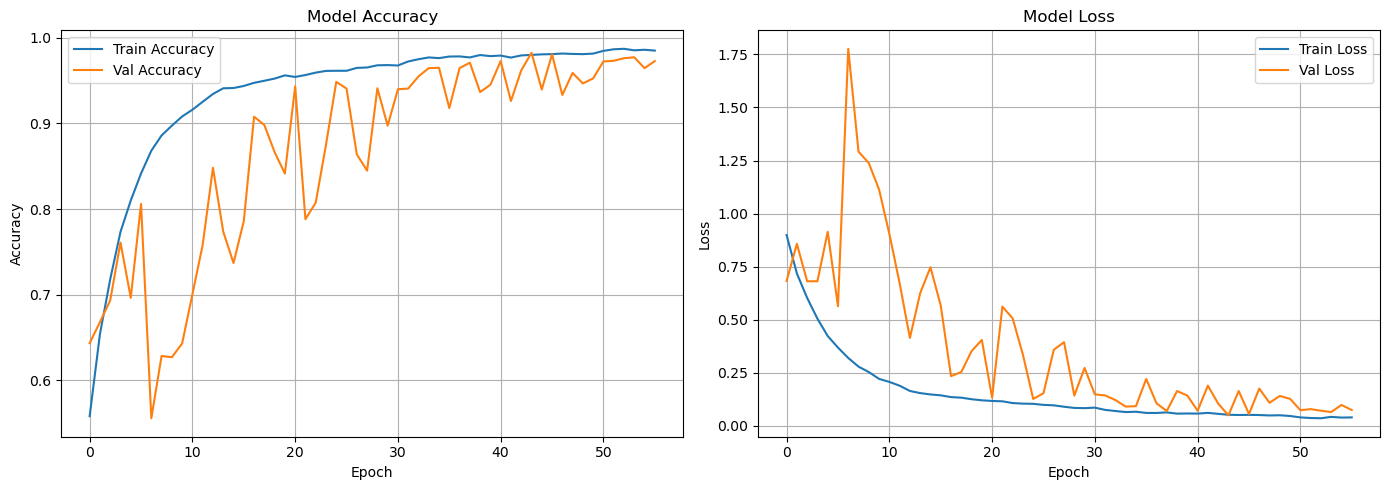


[5/6] Loading best model and evaluating...


Loaded best model: best_cnn_spectrogram.h5

MODEL EVALUATION RESULTS


2025-11-20 11:42:29.748934: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_269', 36 bytes spill stores, 36 bytes spill loads




Test Accuracy : 0.9799
F1 Score      : 0.9798
ROC-AUC Score : 0.9980
Threshold     : 0.5

Classification Report:
              precision    recall  f1-score   support

        Real     0.9756    0.9843    0.9800      1341
        Fake     0.9842    0.9754    0.9798      1340

    accuracy                         0.9799      2681
   macro avg     0.9799    0.9799    0.9799      2681
weighted avg     0.9799    0.9799    0.9799      2681



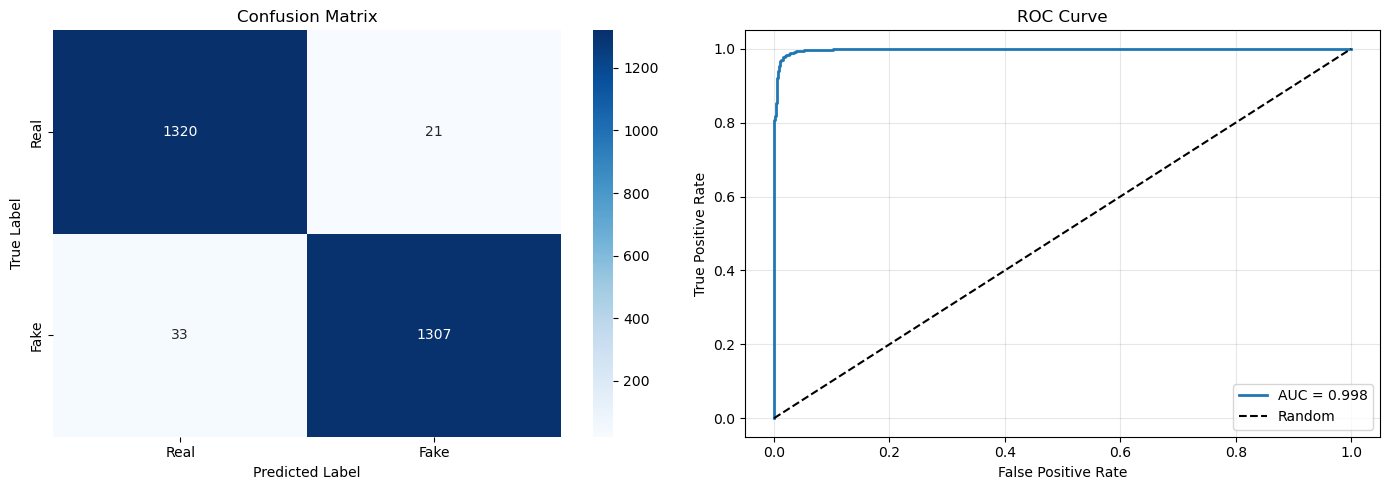

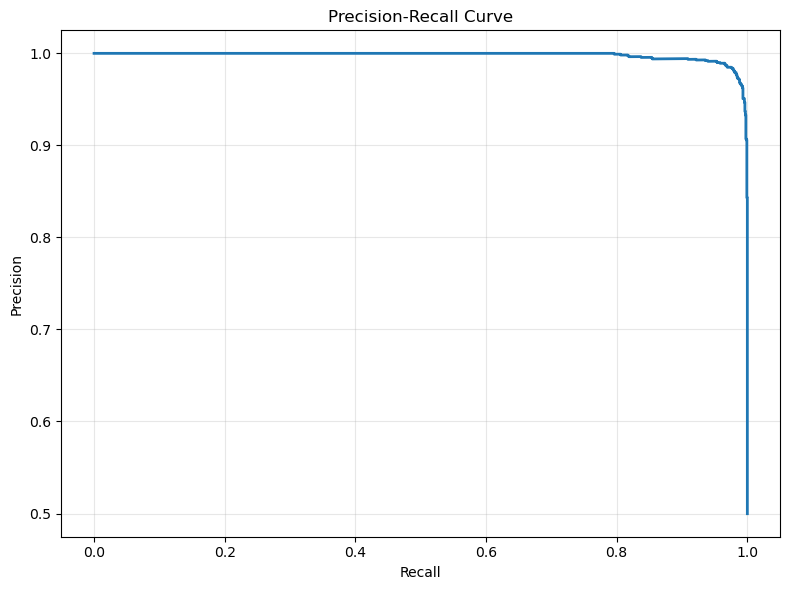


[6/6] Testing single file prediction...

SINGLE FILE PREDICTION
File: file100.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav

Prediction    : FAKE
Confidence    : 0.9997
Threshold     : 0.5


PROCESS COMPLETE!

Final Results:
  Test Accuracy : 0.9799
  F1 Score      : 0.9798
  ROC-AUC       : 0.9980

Model saved as: best_cnn_spectrogram.h5



In [163]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
BASE_PATH ='/home/amrutha/for-2seconds/'
MODEL_FILENAME = 'best_cnn_spectrogram.h5' # Changed to non-CNN specific name for ModelCheckpoint

SAMPLE_RATE = 16000
DURATION = 2.0
N_MELS = 128
HOP_LENGTH = 512
N_MFCC = 40

# Training Parameters
# ❗ FIX 1: Reduced BATCH_SIZE for CUDNN stability
BATCH_SIZE = 16 
EPOCHS = 100
LEARNING_RATE = 1e-4
PATIENCE = 12

# Random Seed for Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ❗ FIX 2: Set memory growth to prevent CUDNN_STATUS_EXECUTION_FAILED
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Only allocate memory as needed, instead of pre-allocating all memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"TensorFlow GPU configuration failed: {e}")

# =================================================================
#               FEATURE SHAPE: Calculate and Normalize
# =================================================================

def get_feature_shape(sr: int = SAMPLE_RATE, duration: float = DURATION, 
                      hop_length: int = HOP_LENGTH, n_mels: int = N_MELS, 
                      n_mfcc: int = N_MFCC) -> Tuple[int, int]:
    """Calculates the fixed feature shape (height, width)."""
    target_length = int(sr * duration)
    # Estimate time steps (width) based on fixed audio length
    n_fft = 2048 
    time_steps = int(np.floor(1 + (target_length - n_fft) / hop_length))
    # Feature height: N_MELS (Mel) + N_MFCC (MFCC)
    height = n_mels + n_mfcc
    return height, time_steps

# Calculate the global target shape once
FEATURE_HEIGHT, FEATURE_WIDTH = get_feature_shape()


def normalize_feature_shape(feature: np.ndarray, target_height: int = FEATURE_HEIGHT, 
                            target_width: int = FEATURE_WIDTH) -> np.ndarray:
    """Pads or truncates a feature array to the fixed target shape."""
    current_height, current_width = feature.shape

    if current_height != target_height:
        # This check is crucial for ensuring correct feature stacking
        raise ValueError(f"Feature height mismatch! Expected {target_height}, got {current_height}.")

    # Width (Time) check
    if current_width < target_width:
        padding = target_width - current_width
        feature = np.pad(feature, ((0, 0), (0, padding)), mode='constant')
    elif current_width > target_width:
        feature = feature[:, :target_width]
    
    return feature

# =================================================================
#                 DATA AUGMENTATION FUNCTIONS
# =================================================================

def time_stretch(audio: np.ndarray, rate: float = None) -> np.ndarray:
    """Apply time stretching to audio."""
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)
    # ❗ FIX 3: Removed 'fill_value' argument to resolve Librosa error
    return librosa.effects.time_stretch(audio, rate=rate)


def pitch_shift(audio: np.ndarray, sr: int, n_steps: int = None) -> np.ndarray:
    """Apply pitch shifting to audio."""
    if n_steps is None:
        n_steps = np.random.randint(-3, 4)
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)


def add_noise(audio: np.ndarray, noise_factor: float = None) -> np.ndarray:
    """Add random noise to audio."""
    if noise_factor is None:
        noise_factor = np.random.uniform(0.001, 0.005)
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise


def spec_augment(spec: np.ndarray, 
                 num_freq_masks: int = 2, 
                 num_time_masks: int = 2) -> np.ndarray:
    """Apply SpecAugment to mel spectrogram."""
    spec = spec.copy()
    freq_bins, time_steps = spec.shape
    
    # Frequency masking
    for _ in range(num_freq_masks):
        f = np.random.randint(0, 15)
        f0 = np.random.randint(0, freq_bins - f)
        spec[f0:f0+f, :] = 0
    
    # Time masking
    for _ in range(num_time_masks):
        t = np.random.randint(0, 20)
        t0 = np.random.randint(0, time_steps - t)
        spec[:, t0:t0+t] = 0
    
    return spec

# =================================================================
#                   FEATURE EXTRACTION FUNCTIONS
# =================================================================

def extract_mel_spectrogram(audio: np.ndarray, sr: int) -> np.ndarray:
    """Extract mel spectrogram from audio."""
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


def extract_mfcc(audio: np.ndarray, sr: int) -> np.ndarray:
    """Extract MFCC features from audio."""
    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=N_MFCC, hop_length=HOP_LENGTH
    )
    return mfcc


def extract_combined_features(audio: np.ndarray, sr: int) -> np.ndarray:
    """Extract and combine mel spectrogram and MFCC features."""
    mel_spec = extract_mel_spectrogram(audio, sr)
    mfcc = extract_mfcc(audio, sr)
    
    # Combine features: Mel (128) + MFCC (40) = 168 rows
    combined = np.vstack([mel_spec, mfcc])
    return combined


def load_audio_file(file_path: str, 
                    augment: bool = False) -> Optional[np.ndarray]:
    """Load and process a single audio file."""
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Ensure fixed audio length before feature extraction
        target_length = int(SAMPLE_RATE * DURATION)
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)))
        else:
            audio = audio[:target_length]
        
        # Apply augmentation if requested
        if augment:
            aug_choice = np.random.choice(['time', 'pitch', 'noise', 'none'], p=[0.25, 0.25, 0.25, 0.25])
            if aug_choice == 'time':
                audio = time_stretch(audio)
            elif aug_choice == 'pitch':
                audio = pitch_shift(audio, sr)
            elif aug_choice == 'noise':
                audio = add_noise(audio)

        # Re-ensure fixed length after time augmentation (time stretch changes length)
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]

        # Extract features
        features = extract_combined_features(audio, sr)
        
        # Normalize feature shape to the global fixed size
        features = normalize_feature_shape(features)
        
        # Apply SpecAugment randomly during training
        if augment and np.random.random() < 0.3:
            features = spec_augment(features)
        
        return features
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# =================================================================
#               DATA LOADING AND PREPROCESSING
# =================================================================

def load_and_preprocess_data(base_path: str, 
                             augment_train: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load and preprocess audio dataset.
    """
    X_list = []
    y_list = []
    
    # Define dataset splits and labels
    splits = ['train', 'test', 'validation'] if os.path.exists(os.path.join(base_path, 'validation')) else ['train', 'test']
    labels = {'real': 0, 'fake': 1}
    
    for split in splits:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue
            
        print(f"\nLoading {split} data...")
        
        for label_name, label_value in labels.items():
            label_path = os.path.join(split_path, label_name)
            
            if not os.path.exists(label_path):
                print(f"Warning: {label_path} not found, skipping...")
                continue
            
            audio_files = [f for f in os.listdir(label_path) if f.endswith('.wav')]
            print(f"  Found {len(audio_files)} {label_name} files in {split}")
            
            for i, filename in enumerate(audio_files):
                file_path = os.path.join(label_path, filename)
                
                # Apply augmentation only to training data
                apply_aug = augment_train and split == 'train'
                features = load_audio_file(file_path, augment=apply_aug)
                
                if features is not None:
                    X_list.append(features)
                    y_list.append(label_value)
                
                if (i + 1) % 100 == 0:
                    print(f"    Processed {i + 1}/{len(audio_files)} files...")
    
    # Convert to numpy arrays
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Add channel dimension for CNN
    X = X[..., np.newaxis]
    
    print(f"\nTotal samples loaded: {len(X)}")
    print(f"Feature shape: {X.shape}")
    print(f"Label distribution: Real={np.sum(y==0)}, Fake={np.sum(y==1)}")
    
    return X, y


# =================================================================
#                   MODEL ARCHITECTURE
# =================================================================

def build_advanced_cnn_model(input_shape: Tuple[int, int, int]) -> keras.Model:
    """
    Build an advanced CNN model with residual connections and attention.
    """
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Residual Block 1
    residual = x
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Adjust residual dimensions if needed
    residual = layers.Conv2D(64, (1, 1), padding='same')(residual)
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Residual Block 2
    residual = x
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    residual = layers.Conv2D(128, (1, 1), padding='same')(residual)
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Residual Block 3
    residual = x
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    residual = layers.Conv2D(256, (1, 1), padding='same')(residual)
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='DeepfakeDetector')
    return model

# =================================================================
#               TRAINING AND EVALUATION
# =================================================================

def plot_training_history(history):
    """Plot training history."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


def evaluate_model(model, X_test, y_test, threshold=0.5):
    """Comprehensive model evaluation."""
    print("\n" + "="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    
    # Predictions
    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob >= threshold).astype(int)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\nTest Accuracy : {accuracy:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print(f"ROC-AUC Score : {roc_auc:.4f}")
    print(f"Threshold     : {threshold}\n")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=['Real', 'Fake'], 
                                digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'], ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_title('ROC Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc='lower right')

        
    plt.tight_layout()
    plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, linewidth=2)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return accuracy, roc_auc, f1


def predict_single_file(model, file_path: str, threshold: float = 0.5):
    """Predict whether a single audio file is real or fake."""
    print(f"\n{'='*60}")
    print("SINGLE FILE PREDICTION")
    print(f"{'='*60}")
    print(f"File: {os.path.basename(file_path)}")
    
    features = load_audio_file(file_path, augment=False)
    
    if features is None:
        print("[ERROR] Could not load audio file")
        return
    
    # Add batch and channel dimensions
    features = features[np.newaxis, ..., np.newaxis]
    
    # Predict
    prob = model.predict(features, verbose=0)[0][0]
    prediction = "FAKE" if prob >= threshold else "REAL"
    
    print(f"\nPrediction    : {prediction}")
    print(f"Confidence    : {prob:.4f}")
    print(f"Threshold     : {threshold}")
    print(f"{'='*60}\n")
    
    return prediction, prob


# =================================================================
#                       MAIN EXECUTION
# =================================================================

def main():
    """Main execution function."""
    
    print("\n" + "="*60)
    print("AUDIO DEEPFAKE DETECTION SYSTEM")
    print("="*60)
    
    # -------------------------------------------------------------
    # 1. Load and Prepare Data
    # -------------------------------------------------------------
    print("\n[1/6] Loading and preprocessing data...")
    X, y = load_and_preprocess_data(BASE_PATH, augment_train=True)
    
    # Split Dataset (70% Train, 15% Val, 15% Test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=RANDOM_SEED, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=RANDOM_SEED, stratify=y_temp
    )
    
    print("\nDataset shapes:")
    print(f"  Train: {X_train.shape}, {y_train.shape}")
    print(f"  Val  : {X_val.shape}, {y_val.shape}")
    print(f"  Test : {X_test.shape}, {y_test.shape}")
    
    # Calculate class weights for imbalanced datasets
    class_weights = {
        0: len(y_train) / (2 * np.sum(y_train == 0)),
        1: len(y_train) / (2 * np.sum(y_train == 1))
    }
    print(f"\nClass weights: {class_weights}")
    
    # -------------------------------------------------------------
    # 2. Build and Compile Model
    # -------------------------------------------------------------
    print("\n[2/6] Building model...")
    input_shape = X_train.shape[1:]
    model = build_advanced_cnn_model(input_shape)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\nModel input shape: {input_shape}")
    model.summary()
    
    # -------------------------------------------------------------
    # 3. Train Model
    # -------------------------------------------------------------
    print("\n[3/6] Training model...")
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss', 
            patience=PATIENCE, 
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            MODEL_FILENAME, 
            monitor='val_loss', 
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=6, 
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE, # ❗ Using the reduced BATCH_SIZE (16)
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    print("\n[Training Completed]")
    
    # -------------------------------------------------------------
    # 4. Plot Training History
    # -------------------------------------------------------------
    print("\n[4/6] Plotting training history...")
    plot_training_history(history)
    
    # -------------------------------------------------------------
    # 5. Load Best Model and Evaluate
    # -------------------------------------------------------------
    print("\n[5/6] Loading best model and evaluating...")
    
    try:
        best_model = keras.models.load_model(MODEL_FILENAME)
        print(f"Loaded best model: {MODEL_FILENAME}")
    except Exception as e:
        print(f"Could not load checkpoint: {e}")
        print("Using the final trained model instead.")
        best_model = model
    
    accuracy, roc_auc, f1 = evaluate_model(best_model, X_test, y_test, threshold=0.5)
    
    # -------------------------------------------------------------
    # 6. Test Single File Prediction
    # -------------------------------------------------------------
    print("\n[6/6] Testing single file prediction...")
    
    # Try to find a sample file
    sample_file = None
    for split in ['test', 'train']:
        for label in ['fake', 'real']:
            test_dir = os.path.join(BASE_PATH, split, label)
            if os.path.exists(test_dir):
                files = [f for f in os.listdir(test_dir) if f.endswith('.wav')]
                if files:
                    sample_file = os.path.join(test_dir, files[0])
                    break
        if sample_file:
            break
    
    if sample_file and os.path.exists(sample_file):
        predict_single_file(best_model, sample_file, threshold=0.5)
    else:
        print("\n[INFO] No sample file found for single prediction test.")
    
    print("\n" + "="*60)
    print("PROCESS COMPLETE!")
    print("="*60)
    print(f"\nFinal Results:")
    print(f"  Test Accuracy : {accuracy:.4f}")
    print(f"  F1 Score      : {f1:.4f}")
    print(f"  ROC-AUC       : {roc_auc:.4f}")
    print(f"\nModel saved as: {MODEL_FILENAME}")
    print("="*60 + "\n")


if __name__ == "__main__":
    main()